In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 4.6MB/s 


In [3]:
import nibabel as nib
import nilearn as nil
from nilearn.plotting import view_img, glass_brain, plot_anat, plot_epi
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [4]:
#os.listdir('/content/drive/My Drive/MICCAI_BraTS/2020/train/2D/mask')

In [5]:
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
def process_path(file_path):
    
    sep = '/'
    name_mask = file_path.numpy().decode('utf-8')
    parts = name_mask.split('/')
    parts[-2] = 'flair'
    name_flair = sep.join(parts)
    parts[-2] = 't1'
    name_t1 = sep.join(parts)
    parts[-2] = 't1ce'
    name_t1ce = sep.join(parts)
    parts[-2] = 't2'
    name_t2 = sep.join(parts)

    mask = cv2.imread(name_mask)[:,:,0]
    flair = cv2.imread(name_flair)[:,:,0]
    t1 = cv2.imread(name_t1)[:,:,0]
    t1ce = cv2.imread(name_t1ce)[:,:,0]
    t2 = cv2.imread(name_t2)[:,:,0]

    img = np.stack((flair, t1, t1ce, t2), axis=-1)

    return img, mask

In [7]:
def get_images(file_path):
    img, mask = process_path(file_path)

    img = tf.convert_to_tensor(img/255, tf.float64)
    mask = tf.convert_to_tensor(mask, tf.float64)
    mask = tf.reshape(mask, (240,240,1))

    '''mask_wt = tf.logical_or(tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 100)), tf.equal(mask, 200))
    mask_wt = tf.cast(mask_wt, tf.float64)
    
    mask_tc = tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 200))
    mask_tc = tf.cast(mask_tc, tf.float64)

    mask_et =tf.equal(mask, 200)
    mask_et = tf.cast(mask_et, tf.float64)

    label = tf.stack([mask_wt, mask_tc, mask_et], axis=-1)'''

    return img, mask

In [8]:
def get_images_wrapper(file_path):
    a, b = tf.py_function(get_images, [file_path], [tf.float64, tf.float64])
    return a, b

In [9]:
train_data = tf.data.Dataset.list_files('/content/drive/My Drive/MICCAI_BraTS/2020/train/2D/mask/*')
train_data = train_data.map(get_images_wrapper, num_parallel_calls=AUTO).cache().batch(2).prefetch(buffer_size=AUTO)

UnknownError: ignored

In [ ]:
c, d = next(iter(train_data))
c.shape, d.shape

In [ ]:
def down_conv_vnet(input_mat, n_layers, reps):
    
    ip = input_mat

    for i in range(reps):
        c1 = Conv2D(n_layers, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='random_normal')(ip)
        ip = PReLU()(c1)

    add1 = add([input_mat, ip])

    return ip   

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    ''' Dice Coefficient
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''

    class_num = 1
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [ ]:
def dice_coef_loss(y_true, y_pred):
    ''' Dice Coefficient Loss
    Args:
        y_true (np.array): Ground Truth Heatmap (Label)
        y_pred (np.array): Prediction Heatmap
    '''
    return 1-dice_coef(y_true, y_pred)

In [22]:
def new_model2():
    input1 = Input(shape=(240,240,4))
    c1 = Conv2D(16, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='random_normal')(input1) # 240x240x16
    c1 = PReLU()(c1)                                                                                                          
    repeat1 = concatenate(4 * [input1], axis=-1) # 240x240x16                                    
    add1 = add([c1, repeat1]) # 240x240x16

    down1 = Conv2D(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add1) # 120x120x32                
    layer1 = PReLU()(down1) 

    add2 = down_conv_vnet(layer1, 32, 1) # 120x120x32                                                                           
    down2 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add2) # 60x60x64
    layer2 = PReLU()(down2)                                 

    add3 = down_conv_vnet(layer2, 64, 1) # 60x60x64
    down3 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add3) # 30x30x128
    layer3 = PReLU()(down3)

    add4 = down_conv_vnet(layer3, 128, 1) # 30x30x128

    # fc output
    up1 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add4) # 60x60x64
    layer4 = PReLU()(up1)

    add5 = down_conv_vnet(concatenate([layer4, add3]), 128, 1) # 60x60x128
    up2 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add5) # 120x120x32
    layer5 = PReLU()(up2)
    
    add6 = down_conv_vnet(concatenate([layer5, add2]), 64, 1) # 120x120x64
    up3 = Conv2DTranspose(16, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add6) # 240x240x16
    layer6 = PReLU()(up3)

    add7 = down_conv_vnet(concatenate([layer6, add1]), 32, 1) # 240x240x32

    c2 = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='random_normal')(add7) # 240x240x1
    fc_out = Softmax(name='fc_out')(c2)

    # handle encoding
    tiles = Reshape((240, 240, 2))(add4) # 240x240x2
    
    # tc output

    input2 = concatenate([fc_out, tiles]) # 240x240x3
    
    down4 = Conv2D(32, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer='random_normal')(input2) # 240x240x32

    add8 = down_conv_vnet(down4, 32, 1) # 240x240x32
    down5 = Conv2D(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add8) # 120x120x64
    layer7 = PReLU()(down5) 

    add9 = down_conv_vnet(layer7, 64, 1) # 120x120x64
    down6 = Conv2D(128, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add9) # 60x60x128
    layer8 = PReLU()(down6)

    up4 = Conv2DTranspose(64, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(layer8) # 120x120x64
    layer9 = PReLU()(up4)

    add10 = down_conv_vnet(concatenate([layer9, add9]), 128, 1) # 120x120x128
    up5 = Conv2DTranspose(32, kernel_size=(2,2), strides=(2,2), kernel_initializer='random_normal')(add10) # 240x240x32
    layer10 = PReLU()(up5)

    add11 = down_conv_vnet(concatenate([layer10, add8]), 64, 1) # 240x240x64

    c3 = Conv2D(1, kernel_size=(1,1), strides=(1,1), kernel_initializer='random_normal')(add11) # 240x240x1
    tc_out = Softmax(name='tc_out')(c3)

    model = Model(inputs=input1, outputs=[fc_out, tc_out])
    return model

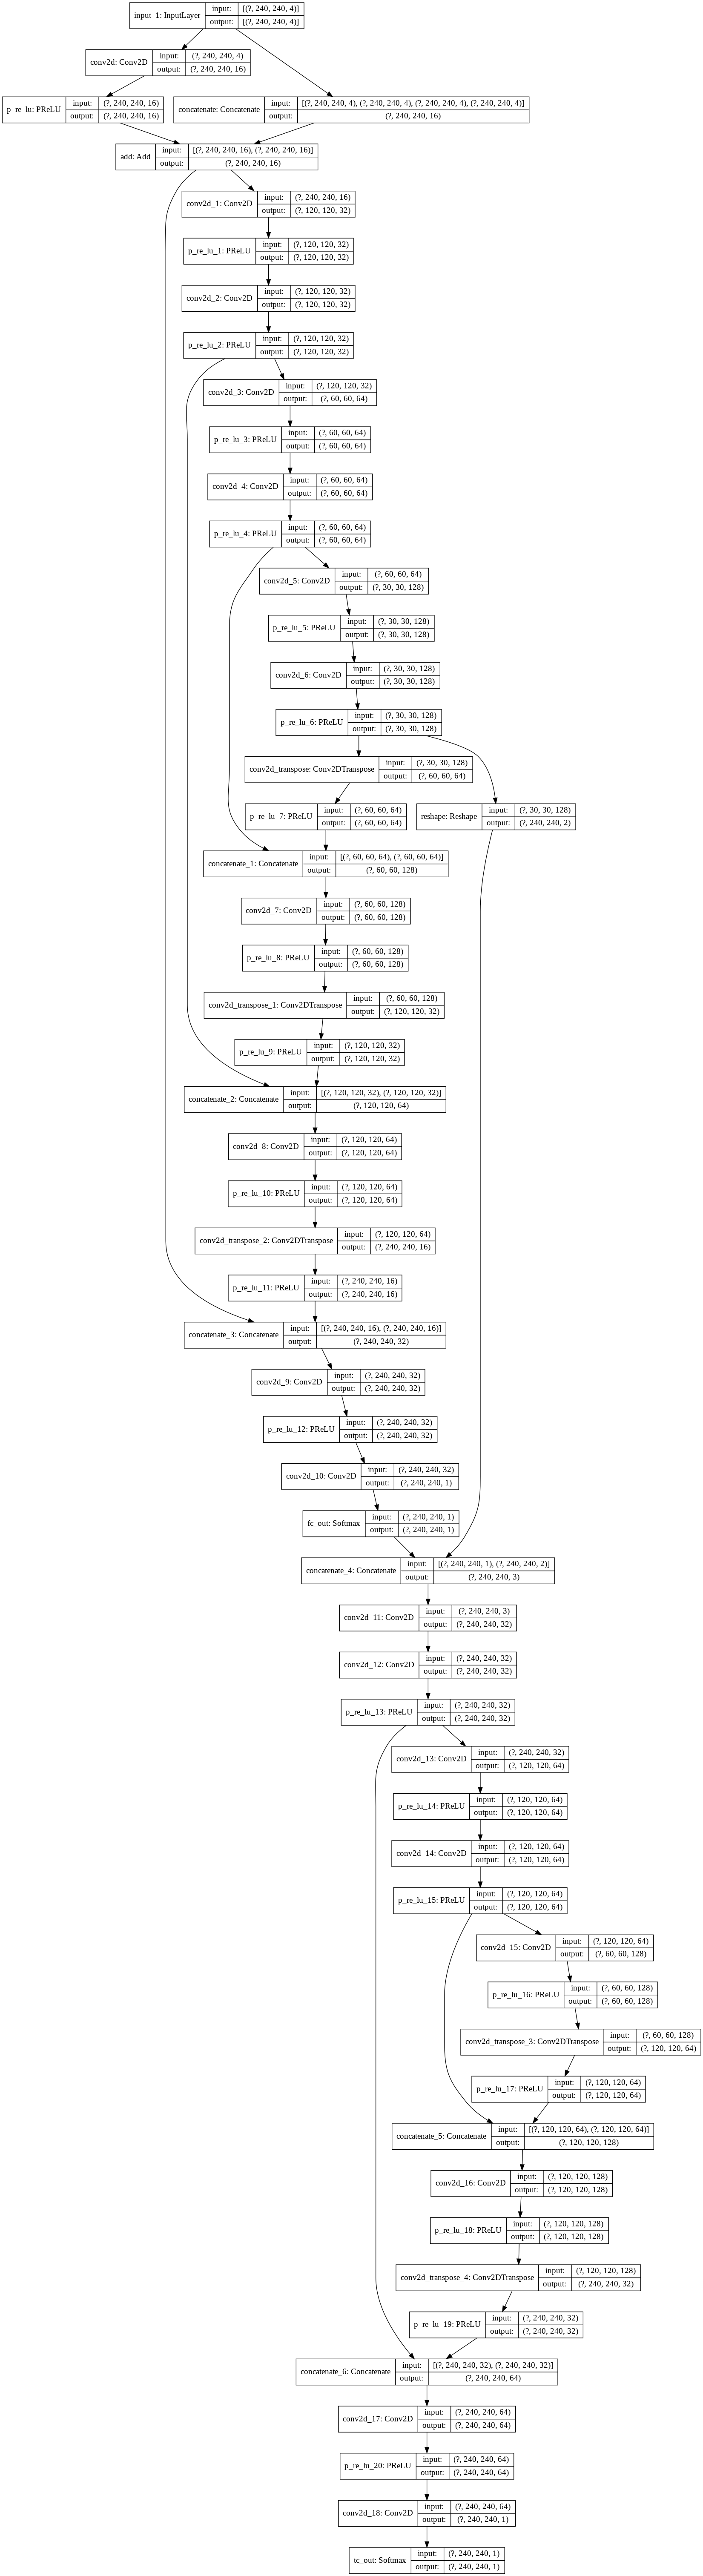

In [23]:
model = new_model2()
tf.keras.utils.plot_model(model, show_shapes=True)

In [24]:
model.compile(optimizer=Adam(lr=1e-4), loss=dice_coef_loss, metrics=dice_coef)

In [25]:
EPOCHS = 1

In [ ]:
loss_tracker = []
for ep in range(EPOCHS):
    loss = 0
    steps = 0
    print(ep+1, '/', EPOCHS)
    for (img, mask) in train_data:

        mask_wt = tf.logical_or(tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 100)), tf.equal(mask, 200))
        mask_wt = tf.cast(mask_wt, tf.float64)

        mask_tc = tf.logical_or(tf.equal(mask, 50), tf.equal(mask, 200))
        mask_tc = tf.cast(mask_tc, tf.float64)
        
        model.fit(img, [mask_wt, mask_tc])
        #loss += history[0]
        #steps += 1
        #print('Step : ', steps)#, ', Loss : ', history[0], ', Dice Coeff : ', history[1])

        #printm()
    #loss_tracker.append(loss/steps)

1 / 1
1/1 [==============================] - 0s 2ms/step - loss: 1.9621 - fc_out_loss: 0.9707 - tc_out_loss: 0.9914 - fc_out_dice_coef: 0.0293 - tc_out_dice_coef: 0.0086
